In [1]:
# ライブラリの導入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from biogeme.version import getText # なくても良い（バージョン確認のため導入）
from biogeme.biogeme import BIOGEME
from biogeme.database import Database
from biogeme.expressions import Beta, Variable, log, exp
from biogeme import models
from biogeme.models import loglogit
from biogeme.results_processing import get_pandas_estimated_parameters

/home/shibumtk/B4research/estimate/.venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# biogemeのバージョン確認
print(getText())

getText is deprecated; use get_text instead.


biogeme 3.3.1 [2025-12-16]
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



In [3]:
# マスターデータの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/01master_data/Logit_master6.csv", encoding="utf-8-sig")

# 欠損している部分をすべて0で補完（必要な処理は作成時にやってるから大丈夫）
master_df = master_df.fillna(0)

# 確認
print(len(master_df))
master_df.columns

47468


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation', 'NearestStation_code', 'near_area_syou',
       'near_area_kinrin', 'near_area_sum', 'near_area_syou500',
       'near_area_kinrin500', 'near_area_sum500', 'near_area_syou300',
       'near_area_kinrin300', 'near_area_sum300', 'near_o_area_syou',
       'near_o_area_kinrin', 'near_o_area_sum', 'near_o_area_syou500',
       'near_o_area_kinrin500', 'near_o_area_sum500', 'near_o_area_syou300',
       'near_o_area_kinrin300', 'near_o_area_sum300', 'WorkplaceStation',
       'WorkplaceStation_code', 'WP_area_syou', 'WP_area_kinrin',
       'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500', 'WP_area_sum500',
       'WP_area_syou300', 'WP_area_kinrin300', 'WP_area_sum300',
       'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_area_sum',
       'WP_o_are

In [4]:
# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
master_df = master_df.drop(columns=drop_cols)
master_df.columns

Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation_code', 'near_area_syou', 'near_area_kinrin',
       'near_area_sum', 'near_area_syou500', 'near_area_kinrin500',
       'near_area_sum500', 'near_area_syou300', 'near_area_kinrin300',
       'near_area_sum300', 'near_o_area_syou', 'near_o_area_kinrin',
       'near_o_area_sum', 'near_o_area_syou500', 'near_o_area_kinrin500',
       'near_o_area_sum500', 'near_o_area_syou300', 'near_o_area_kinrin300',
       'near_o_area_sum300', 'WorkplaceStation_code', 'WP_area_syou',
       'WP_area_kinrin', 'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500',
       'WP_area_sum500', 'WP_area_syou300', 'WP_area_kinrin300',
       'WP_area_sum300', 'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_area_sum',
       'WP_o_area_syou500', 'WP_o_area_kinrin500', 'WP_o_area

In [5]:
master_df[['MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdMembers(all)', 'WorkTime[m]', 'near_area_syou300']].describe()

,MainlineTime[m],AccessTime_used[m],HouseholdMembers(all),WorkTime[m],near_area_syou300
count,47468.000000,47468.000000,47468.00000,47468.000000,4.746800e+04
mean,55.917761,10.387202,2.60072,604.826367,4.387182e+05
std,24.009200,5.843204,1.23057,102.672286,4.530695e+05
min,6.642953,1.184588,1.00000,248.000000,0.000000e+00
25%,38.370306,5.968356,2.00000,550.000000,0.000000e+00
50%,52.999831,9.208647,3.00000,600.000000,3.213211e+05
75%,71.137090,13.610342,4.00000,660.000000,6.878829e+05
max,142.063611,37.509687,9.00000,900.000000,2.981425e+06


In [6]:
# biogeme.databaseに格納
master_db = Database("PTdata", master_df)

In [7]:
# 変数（main の DB）
PRITRIP   = Variable("PriTrip")                 # 目的変数（0/1）
MACM_min  = Variable("MainlineTime[m]")         # 本線（分）
WORK_min  = Variable("WorkTime[m]")             # 就業（分）
HHM       = Variable("HouseholdMembers(all)")   # 世帯人数
LU        = Variable("near_area_syou300")       # 駅土地利用指標
AT_min    = Variable("AccessTime_used[m]")      # その日の実際の端末時間（分）
MODE      = Variable("first_transportation")    # 1:歩, 2:自転車, 4:バス, 5:車

# スケーリング
MACM_h = master_db.define_variable("MACM_h",  MACM_min / 60)   # /時
WORK_h = master_db.define_variable("WORK_h",  WORK_min / 60)   # /時
LU_s   = master_db.define_variable("LU_s",    LU / 1000000) # 1,000,000㎡あたり
AT_c   = master_db.define_variable("AT_c",    AT_min - np.mean(master_df["AccessTime_used[m]"])) 

# 各モード利用可否
WALK_AV    = Variable("walk_av")
BICYCLE_AV = Variable("bicycle_av")
BUS_AV     = Variable("bus_av")
CAR_AV     = Variable("car_av")

# モード・ダミー（歩=基準なので作らない）
D_BIC = master_db.define_variable("D_BIC", (MODE == 2))
D_BUS = master_db.define_variable("D_BUS", (MODE == 4))
D_CAR = master_db.define_variable("D_CAR", (MODE == 5))
D_WAL = master_db.define_variable("D_WAL", (MODE == 1)) # 交差項用に使う

# 交差項：端末時間 × モード（4本）
#AT_WAL = master_db.define_variable("AT_WAL", AT_c * D_WAL)
#AT_BIC = master_db.define_variable("AT_BIC", AT_c * D_BIC)
#AT_BUS = master_db.define_variable("AT_BUS", AT_c * D_BUS)
#AT_CAR = master_db.define_variable("AT_CAR", AT_c * D_CAR)

AT_WAL = master_db.define_variable("AT_WAL", AT_min * D_WAL)
AT_BIC = master_db.define_variable("AT_BIC", AT_min * D_BIC)
AT_BUS = master_db.define_variable("AT_BUS", AT_min * D_BUS)
AT_CAR = master_db.define_variable("AT_CAR", AT_min * D_CAR)

# 係数
ASC_YES  = Beta("ASC_YES", 0.0, None, None, 0)
B_MACM   = Beta("B_MACMTIME", -0.01, None, None, 0)  # /時
B_WORK   = Beta("B_WORKTIME", -0.30, None, None, 0)  # /時
B_HH     = Beta("B_HHM_all",  0.0, None, None, 0)
B_LU     = Beta("B_N_EKI_SCORE", 0.0, None, None, 0) # 駅土地利用を入れるなら

# モード・ダミー（歩が基準）→ 定数のずれ
B_D_BIC  = Beta("B_D_BICYCLE", 0.0, None, None, 0)
B_D_BUS  = Beta("B_D_BUS",     0.0, None, None, 0)
B_D_CAR  = Beta("B_D_CAR",     0.0, None, None, 0)

# 端末時間のモード別傾き（/分）
B_AT_WAL = Beta("B_AT_WALK",    -0.01, None, None, 0)
B_AT_BIC = Beta("B_AT_BICYCLE", -0.01, None, None, 0)
B_AT_BUS = Beta("B_AT_BUS",     -0.01, None, None, 0)
B_AT_CAR = Beta("B_AT_CAR",     -0.01, None, None, 0)

In [8]:
# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         + B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_BIC * D_BIC + B_D_BUS * D_BUS + B_D_CAR * D_CAR
         + B_AT_WAL * AT_WAL + B_AT_BIC * AT_BIC + B_AT_BUS * AT_BUS + B_AT_CAR * AT_CAR)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio = BIOGEME(master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio.model_name = "binlogit_mode_dummies_time_interactions"
bio.calculate_null_loglikelihood(avail={0:1, 1:1})
res = bio.estimate()
print(res.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results = get_pandas_estimated_parameters(estimation_results=res)
print(pandas_results)

Results for model binlogit_mode_dummies_time_interactions
Nbr of parameters:		12
Sample size:			47468
Excluded data:			0
Null log likelihood:		-32902.31
Final log likelihood:		-19145.54
Likelihood ratio test (null):		27513.54
Rho square (null):			0.418
Rho bar square (null):			0.418
Akaike Information Criterion:	38315.08
Bayesian Information Criterion:	38420.3

             Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         ASC_YES  4.442185         0.094611       46.952091    0.000000e+00
1      B_MACMTIME -0.553911         0.034830      -15.903202    0.000000e+00
2      B_WORKTIME -0.491332         0.008508      -57.752044    0.000000e+00
3       B_HHM_all -0.242413         0.011900      -20.370187    0.000000e+00
4   B_N_EKI_SCORE  0.089008         0.029010        3.068192    2.153583e-03
5     B_D_BICYCLE -0.036752         0.103667       -0.354518    7.229506e-01
6         B_D_BUS  0.001171         0.167461        0.006991    9.944223e-01
7         B_D_CAR -0

In [9]:
# 全共通の時間パラメータと各モード別の時間パラメータと分けることでより精度を上げる
# 全モード共通の「時間の傾き」（これで全体のN数49,000件のパワーを使う）
B_AT_BASE = Beta("B_AT_BASE", -0.015, None, None, 0) # AT_cを掛ける
# これを導入することで各モード別のパラメータの標準誤差を小さくする
# この値と各モード別の時間パラメータの和がそのモードの時間パラメータとなる

# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         + B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_BIC * D_BIC + B_D_BUS * D_BUS + B_D_CAR * D_CAR
         + B_AT_BASE * AT_min + B_AT_BIC * AT_BIC + B_AT_BUS * AT_BUS + B_AT_CAR * AT_CAR)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio = BIOGEME(master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio.model_name = "binlogit_mode_dummies_time_interactions3"
bio.calculate_null_loglikelihood(avail={0:1, 1:1})
res3 = bio.estimate()
print(res3.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results3 = get_pandas_estimated_parameters(estimation_results=res3)
print(pandas_results3)

Results for model binlogit_mode_dummies_time_interactions3
Nbr of parameters:		12
Sample size:			47468
Excluded data:			0
Null log likelihood:		-32902.31
Final log likelihood:		-19145.54
Likelihood ratio test (null):		27513.54
Rho square (null):			0.418
Rho bar square (null):			0.418
Akaike Information Criterion:	38315.08
Bayesian Information Criterion:	38420.3

             Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         ASC_YES  4.442142         0.094611       46.951832    0.000000e+00
1      B_MACMTIME -0.553909         0.034830      -15.903161    0.000000e+00
2      B_WORKTIME -0.491329         0.008508      -57.751938    0.000000e+00
3       B_HHM_all -0.242413         0.011900      -20.370172    0.000000e+00
4   B_N_EKI_SCORE  0.089008         0.029010        3.068201    2.153514e-03
5     B_D_BICYCLE -0.036695         0.103667       -0.353974    7.233587e-01
6         B_D_BUS  0.001294         0.167461        0.007730    9.938324e-01
7         B_D_CAR -

In [10]:
# 新たな変数の追加
# 変数の定義
D_VEHICLE  = master_db.define_variable("D_VEHICLE", (MODE != 1))
AT_VEHICLE = master_db.define_variable("AT_VEHICLE", AT_c * D_VEHICLE)

# 2. 徒歩以外を使うことの定数項（乗り物に乗る面倒さ/楽さ）と時間
#    これだけで、車・バス・自転車の「徒歩との違い」をまとめて吸収
B_AT_VEHICLE = Beta("B_AT_VEHICLE", -0.01, None, None, 0)
B_D_VEHICLE  = Beta("B_D_VEHICLE", 0.0, None, None, 0)

# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         + B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_VEHICLE * D_VEHICLE
         #+ B_AT_BASE * AT_c 
         + B_AT_WAL * AT_WAL 
         + B_AT_VEHICLE * AT_VEHICLE)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio = BIOGEME(master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio.model_name = "binlogit_mode_dummies_time_interactions2"
bio.calculate_null_loglikelihood(avail={0:1, 1:1})
res4 = bio.estimate()
print(res4.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results4 = get_pandas_estimated_parameters(estimation_results=res4)
print(pandas_results4)

Results for model binlogit_mode_dummies_time_interactions2
Nbr of parameters:		8
Sample size:			47468
Excluded data:			0
Null log likelihood:		-32902.31
Final log likelihood:		-19146.79
Likelihood ratio test (null):		27511.03
Rho square (null):			0.418
Rho bar square (null):			0.418
Akaike Information Criterion:	38309.59
Bayesian Information Criterion:	38379.73

            Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0        ASC_YES  4.447952         0.094570       47.033648    0.000000e+00
1     B_MACMTIME -0.558058         0.034710      -16.077586    0.000000e+00
2     B_WORKTIME -0.491356         0.008508      -57.752908    0.000000e+00
3      B_HHM_all -0.243337         0.011890      -20.465208    0.000000e+00
4  B_N_EKI_SCORE  0.087758         0.028997        3.026484    2.474161e-03
5    B_D_VEHICLE -0.295917         0.044245       -6.688112    2.260681e-11
6      B_AT_WALK -0.018147         0.003043       -5.964224    2.457997e-09
7   B_AT_VEHICLE -0.016910 

# 推定結果の可視化（感度分析）

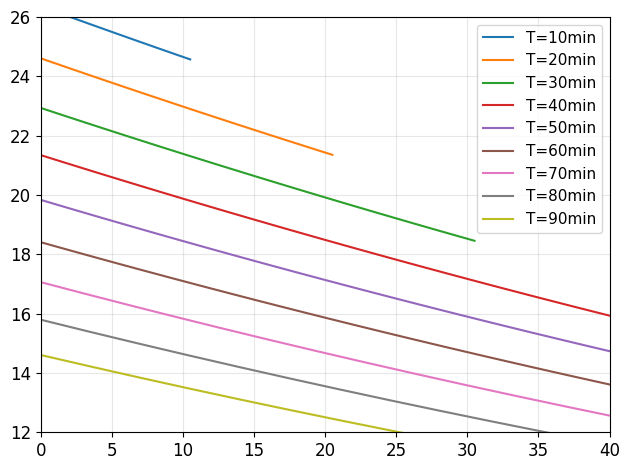

In [11]:
# 総通勤時間固定の端末とメイン変動による私事トリップ割合（mode=徒歩）
# 推定済み係数の取得
beta = res.get_beta_values()

# 代表値（固定値）の指定
work_time = master_df["WorkTime[m]"].mean()/60 # 時間
HHM = 2 # 世帯人数2人
lu  = 677535.273703768/1e6 # 阿佐ヶ谷駅 1,000,000㎡あたり
# 端末交通
D_bicycle = 0
D_bus = 0
D_car = 0

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# 感度分析の設定
totals = range(10, 91, 10) # 10, 20, ..., 90分
step = 0.5 # 0.5分ずつ

plt.figure() # 描画スペースの決定

for T in totals:
    AT = np.arange(0, T + 1, step)
    MACM = T - AT
    MACM_h = MACM/60

    V = (
        beta["ASC_YES"]
        + beta["B_WORKTIME"] * work_time
        + beta["B_HHM_all"] * HHM
        + beta["B_MACMTIME"] * MACM_h
        + beta["B_AT_WALK"] * AT
        + beta["B_N_EKI_SCORE"] * lu
        # その他，交通モードの効用は0であるため，省略
    )

    P = logistic(V)
    plt.plot(AT, P*100, label=f"T={T}min")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlabel("AT (min) [walking]")
#plt.ylabel("Private-trip probability")
plt.xlim(0, 40)
plt.ylim(12, 26)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [12]:
# 実際のポイント計算
beta = res.get_beta_values()
sum_times = [30, 60, 90]
access_times = [5, 10, 15, 20]

diff_results = []  # 各iの差分をここに貯める

for i in sum_times:
    P_at = {}
    for l in access_times:
        AT = l
        MACM_h = (i - AT)/60
        V = (
        beta["ASC_YES"]
        + beta["B_WORKTIME"] * work_time
        + beta["B_HHM_all"] * HHM
        + beta["B_MACMTIME"] * MACM_h
        + beta["B_AT_WALK"] * AT
        + beta["B_N_EKI_SCORE"] * lu
        # その他，交通モードの効用は0であるため，省略
        )
        P = logistic(V)
        P_at[AT] = logistic(V)
        print(f"総通勤時間{i}分，端末{l}分の私事トリップ確率", P)
    # 差分（符号つき）と絶対差
    delta = P_at[5] - P_at[20]
    abs_delta = abs(delta)

    diff_results.append({
        "sum_time_min": i,
        "P_AT5": P_at[5],
        "P_AT20": P_at[20],
        "delta_P_5_minus_20": delta,
        "abs_delta_P": abs_delta,
    })

# 確認表示
for r in diff_results:
    print(r["sum_time_min"], r["P_AT5"], r["P_AT20"], "差", r["delta_P_5_minus_20"])

総通勤時間30分，端末5分の私事トリップ確率 0.22149294154864646
総通勤時間30分，端末10分の私事トリップ確率 0.21385560888864427
総通勤時間30分，端末15分の私事トリップ確率 0.20641179777243301
総通勤時間30分，端末20分の私事トリップ確率 0.19916144755695608
総通勤時間60分，端末5分の私事トリップ確率 0.17741754720033553
総通勤時間60分，端末10分の私事トリップ確率 0.17096623160240246
総通勤時間60分，端末15分の私事トリップ確率 0.164702530848466
総通勤時間60分，端末20分の私事トリップ確率 0.1586244051136335
総通勤時間90分，端末5分の私事トリップ確率 0.14052961044025947
総通勤時間90分，端末10分の私事トリップ確率 0.13519916578179822
総通勤時間90分，端末15分の私事トリップ確率 0.130040318948504
総通勤時間90分，端末20分の私事トリップ確率 0.12504985606941113
30 0.22149294154864646 0.19916144755695608 差 0.022331493991690377
60 0.17741754720033553 0.1586244051136335 差 0.018793142086702047
90 0.14052961044025947 0.12504985606941113 差 0.015479754370848336


In [13]:
# グラフと同じ前提：T固定で MACM = T - AT
T_b = 50
AT_b = 18
T_p = 60

beta = res.get_beta_values()

# 基準確率（グラフのT=50の線上の AT=15 に対応）
MACM_h_b = (T_b - AT_b) / 60
V_b = (
    beta["ASC_YES"]
    + beta["B_WORKTIME"] * work_time
    + beta["B_HHM_all"] * HHM
    + beta["B_MACMTIME"] * MACM_h_b
    + beta["B_AT_WALK"] * AT_b
    + beta["B_N_EKI_SCORE"] * lu
)
P_b = logistic(V_b)

# 等確率になる AT_p を解く（V_b = V_p）
beta_AT   = beta["B_AT_WALK"]
beta_MACM = beta["B_MACMTIME"]
k = beta_AT - beta_MACM / 60  # ATに掛かる実効係数（グラフ前提）

if np.isclose(k, 0.0):
    raise ValueError("beta_AT - beta_MACM/60 が 0 に近く、AT を一意に求められません。")

access_time_p = AT_b + (beta_MACM * (T_b - T_p) / 60) / k

# 検算：T=60 の線上で同じ確率になるか
MACM_h_p = (T_p - access_time_p) / 60
V_p = (
    beta["ASC_YES"]
    + beta["B_WORKTIME"] * work_time
    + beta["B_HHM_all"] * HHM
    + beta["B_MACMTIME"] * MACM_h_p
    + beta["B_AT_WALK"] * access_time_p
    + beta["B_N_EKI_SCORE"] * lu
)
P_p = logistic(V_p)

print(f"T={T_b}, AT={AT_b} のP={P_b}")
print(f"T={T_p}, AT={access_time_p} のP={P_p}, diff={P_p-P_b}")

T=50, AT=18 のP=0.17389938560328352
T=60, AT=7.7085633861921075 のP=0.17389938560328355, diff=2.7755575615628914e-17


In [14]:
print(res.model_name)         # 期待するモデル名か？
print(sorted(res.get_beta_values().keys()))

binlogit_mode_dummies_time_interactions
['ASC_YES', 'B_AT_BICYCLE', 'B_AT_BUS', 'B_AT_CAR', 'B_AT_WALK', 'B_D_BICYCLE', 'B_D_BUS', 'B_D_CAR', 'B_HHM_all', 'B_MACMTIME', 'B_N_EKI_SCORE', 'B_WORKTIME']


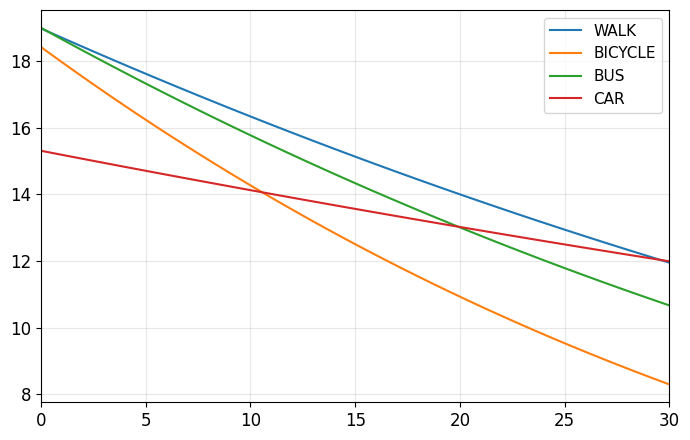

In [15]:
# 端末交通による私事トリップ確率の違い
# 推定済み係数（dict）
beta = res.get_beta_values()

# ===== 固定値（ユーザー指定）=====
work_time = master_df["WorkTime[m]"].mean() / 60     # 時間
MACM_h    = master_df["MainlineTime[m]"].mean() / 60 # 時間
HHM = 2
lu  = 677535.273703768 / 1e6 # 阿佐ヶ谷駅

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# ===== AT のレンジ =====
AT = np.arange(0, 30.0 + 0.5, 0.5)  # 0〜30分, 0.5分刻み

# ===== 共通部分（モードに依らない部分）=====
V_common = (
    beta["ASC_YES"]
    + beta["B_WORKTIME"]   * work_time
    + beta["B_HHM_all"]    * HHM
    + beta["B_N_EKI_SCORE"]* lu
    + beta["B_MACMTIME"]   * MACM_h
)

# ===== モードごとの (ダミー, AT係数) を定義 =====
modes = {
    "WALK":    {"dummy": 0.0,                 "b_at": beta["B_AT_WALK"]},
    "BICYCLE": {"dummy": beta["B_D_BICYCLE"], "b_at": beta["B_AT_BICYCLE"]},
    "BUS":     {"dummy": beta["B_D_BUS"],     "b_at": beta["B_AT_BUS"]},
    "CAR":     {"dummy": beta["B_D_CAR"],     "b_at": beta["B_AT_CAR"]},
}

plt.figure(figsize=(7, 4.5))

for name, info in modes.items():
    V = V_common + info["dummy"] + info["b_at"] * AT
    P = logistic(V)
    plt.plot(AT, P*100, label=name)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlabel("AT (min)")
#plt.ylabel("Private-trip probability")
#plt.title("Sensitivity of private-trip probability to terminal time (by mode)")
plt.xlim(0, 30)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()